## Plot for the match shape compare

/Users/yaqifan/Documents/Github/Pyxis/db/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yaqifan/Documents/Github/Pyxis/db/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yaqifan/Documents/Github/Pyxis/db/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value

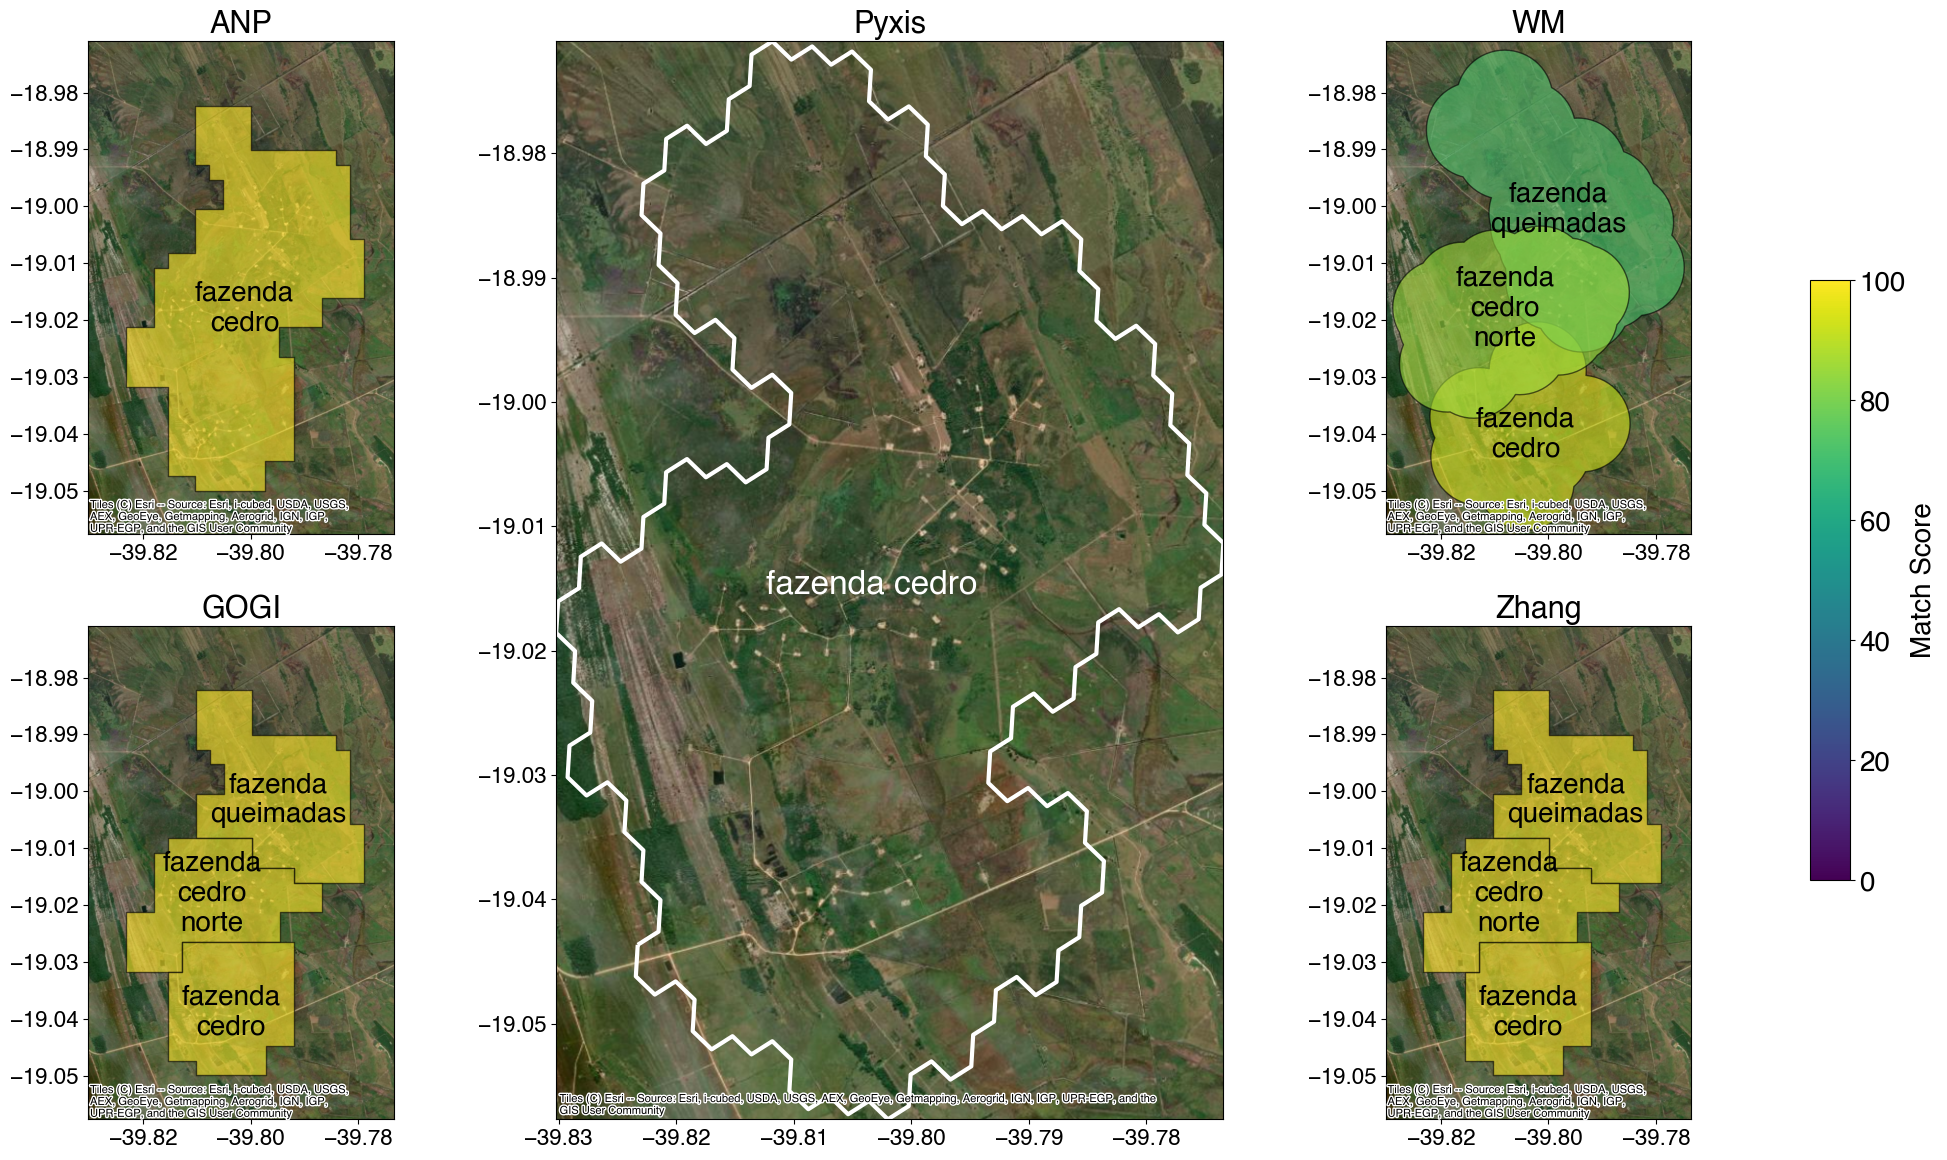

In [3]:
import pandas as pd
import h3
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from shapely import wkt
import contextily as ctx
import matplotlib.colors as mcolors

###prepare h3 boundary

# Load the CSV file with your original data
merged = pd.read_csv('../data/br_geodata/merged_pyxis_field_info_table_filtered_withwm.csv')

# Parse the geometries (assuming they are WKT strings)
merged['geometry'] = merged['geometry'].apply(lambda x: gpd.GeoSeries.from_wkt([x])[0])

# Set the CRS to EPSG:4326 (latitude and longitude)
merged = gpd.GeoDataFrame(merged, geometry='geometry', crs="EPSG:4326")

# Function to handle both Polygon and MultiPolygon geometries
def dissolve_h3_boundary(geometry, resolution=9):
    h3_polygons = []
    
    # Handle MultiPolygon or single Polygon
    if isinstance(geometry, MultiPolygon):
        for polygon in geometry.geoms:  # Use .geoms to iterate over individual polygons in MultiPolygon
            h3_polygons.extend(polygon_to_h3_cells(polygon, resolution))
    elif isinstance(geometry, Polygon):
        h3_polygons.extend(polygon_to_h3_cells(geometry, resolution))
    
    # Dissolve the individual H3 polygons into a single shape
    if h3_polygons:
        dissolved_shape = unary_union(h3_polygons)
        return dissolved_shape
    return None

# Helper function to convert a single Polygon to H3 cells
def polygon_to_h3_cells(polygon, resolution=9):
    geojson_dict = mapping(polygon)
    h3_cells = h3.polyfill(geojson_dict, resolution)
    
    # Convert H3 cells to polygons while ensuring correct [longitude, latitude] order
    return [Polygon([(lng, lat) for lat, lng in h3.h3_to_geo_boundary(cell, geo_json=True)]) for cell in h3_cells]

# Apply the conversion for each field geometry
merged['dissolved_geometry'] = merged['geometry'].apply(dissolve_h3_boundary)

# Convert the results into a GeoDataFrame with CRS set to EPSG:4326
gdf = gpd.GeoDataFrame(merged, geometry='dissolved_geometry', crs="EPSG:4326")


### prepare match fields 
# Set font globally
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 20

# Load the Pyxis match table (replace with your actual CSV file path)
match_table = pd.read_csv('../data/br_geodata/pyxis_match_table_filtered_withwm.csv')
id =  177
# Filter for Pyxis ID 93
pyxis_93_matches = match_table[match_table['Pyxis ID'] == id]

# Load the source data
anp_data = pd.read_csv('../data/br_geodata/data_standardization/anp.csv')
wm_data = pd.read_csv('../data/br_geodata/data_standardization/wm.csv')
zhan_data = pd.read_csv('../data/br_geodata/data_standardization/zhan.csv')
gogi_data = pd.read_csv('../data/br_geodata/data_standardization/gogi.csv')

# Convert the 'geometry' column from WKT format to actual geometry object
anp_data['geometry'] = anp_data['geometry'].apply(wkt.loads)
wm_data['geometry'] = wm_data['geometry'].apply(wkt.loads)
zhan_data['geometry'] = zhan_data['geometry'].apply(wkt.loads)
gogi_data['geometry'] = gogi_data['geometry'].apply(wkt.loads)

# Convert DataFrames to GeoDataFrames
anp_gdf = gpd.GeoDataFrame(anp_data, geometry='geometry', crs="EPSG:4326")
wm_gdf = gpd.GeoDataFrame(wm_data, geometry='geometry', crs="EPSG:4326")
zhan_gdf = gpd.GeoDataFrame(zhan_data, geometry='geometry', crs="EPSG:4326")
gogi_gdf = gpd.GeoDataFrame(gogi_data, geometry='geometry', crs="EPSG:4326")

# Load the H3 Pyxis data (replace with your actual GeoJSON file path)
br_h3 = gdf

# Filter the H3 data for Pyxis ID 93
h3_pyxis_93 = br_h3[br_h3['Pyxis ID'] == id]

# Extract relevant names for labeling (only the first name split by a comma)
field_names = [name.split(',')[0] for name in pyxis_93_matches['Name'].unique()]

# Extract original field shapes and match scores for the four sources
source_data = {
    'anp': {'gdf': anp_gdf, 'label': 'ANP'},
    'wm': {'gdf': wm_gdf, 'label': 'WM'},
    'zhan': {'gdf': zhan_gdf, 'label': 'Zhan'},
    'gogi': {'gdf': gogi_gdf, 'label': 'GOGI'}
}

# Filter each GeoDataFrame for the relevant field IDs
for source_name, data in source_data.items():
    source_matches = pyxis_93_matches[pyxis_93_matches['Source Name'] == source_name]
    field_ids = source_matches['Field ID'].tolist()
    data['filtered_gdf'] = data['gdf'][data['gdf']['Field ID'].isin(field_ids)]
    # Add match score as a column for colormap
    data['filtered_gdf']['match_score'] = source_matches.set_index('Field ID').loc[field_ids, 'Match Score']

### plots
# Create the figure
fig = plt.figure(figsize=(20, 12))

# Use subplot2grid to create the layout
ax1 = plt.subplot2grid((2, 4), (0, 1), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 0))
ax3 = plt.subplot2grid((2, 4), (0, 3))
ax4 = plt.subplot2grid((2, 4), (1, 0))
ax5 = plt.subplot2grid((2, 4), (1, 3))
axes = [ax1, ax2, ax3, ax4, ax5]

# Set the extent for all plots
ax1.set_xlim(h3_pyxis_93.total_bounds[[0, 2]])
ax1.set_ylim(h3_pyxis_93.total_bounds[[1, 3]])

# Add the basemap for ax1 before plotting the data
ctx.add_basemap(ax1, source=ctx.providers.Esri.WorldImagery, crs="EPSG:4326", zoom=14)
# Adjust label positions to avoid overlap in ax1
ax1.tick_params(labelsize=16)
centroid = h3_pyxis_93.geometry.centroid.iloc[0]
ax1.text(centroid.x, centroid.y, field_names[0], fontsize=24, ha='center', color='white', weight='bold', transform=ax1.transData)

# Now plot the H3 Pyxis field on ax1 with edge color only
h3_pyxis_93.plot(ax=ax1, facecolor='none', edgecolor='white', linewidth=3)

# Apply the same x and y limits to all other plots and add the basemap before plotting the data
for ax, (source_name, data) in zip([ax2, ax3, ax4, ax5], source_data.items()):
    ax.tick_params(labelsize=16)
    ax.set_xlim(ax1.get_xlim())  # Apply x limits before adding basemap
    ax.set_ylim(ax1.get_ylim())  # Apply y limits before adding basemap
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="EPSG:4326", zoom=14)  # Add basemap
    data['filtered_gdf'].plot(ax=ax, column='match_score', cmap=plt.cm.viridis, edgecolor='black', linewidth=1, legend=False, norm=mcolors.Normalize(vmin=0, vmax=100), alpha=0.6)

    # Add the field name labels
    for idx, row in data['filtered_gdf'].iterrows():
        field_name = pyxis_93_matches[(pyxis_93_matches['Source Name'] == source_name) & (pyxis_93_matches['Field ID'] == row['Field ID'])]['Name'].values[0].split(',')[0]
        # Split the field name by spaces and join with newline characters
        wrapped_field_name = '\n'.join(field_name.split())
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y-0.005, wrapped_field_name, fontsize=20, color='black', fontweight='bold', ha='center', transform=ax.transData)  # Adjusted alignment to center the text


# Add a colorbar on the right for the match scores
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=mcolors.Normalize(vmin=0, vmax=100))
sm._A = []  # Dummy array for the colorbar
fig.colorbar(sm, cax=cbar_ax, label='Match Score')

# Add titles for each plot
ax1.set_title("Pyxis", fontsize=22, fontweight='bold')
ax2.set_title("ANP", fontsize=22, fontweight='bold')
ax3.set_title("WM", fontsize=22, fontweight='bold')
ax4.set_title("GOGI", fontsize=22, fontweight='bold')
ax5.set_title("Zhang", fontsize=22, fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()

## Plot for Cumulative Information

/var/folders/8z/nrbsy4n11vvd1rdqlg2hf7lw0000gn/T/ipykernel_64061/73134621.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Source', y='Data Richness', data=df, palette='coolwarm', label='Data Richness for Source')


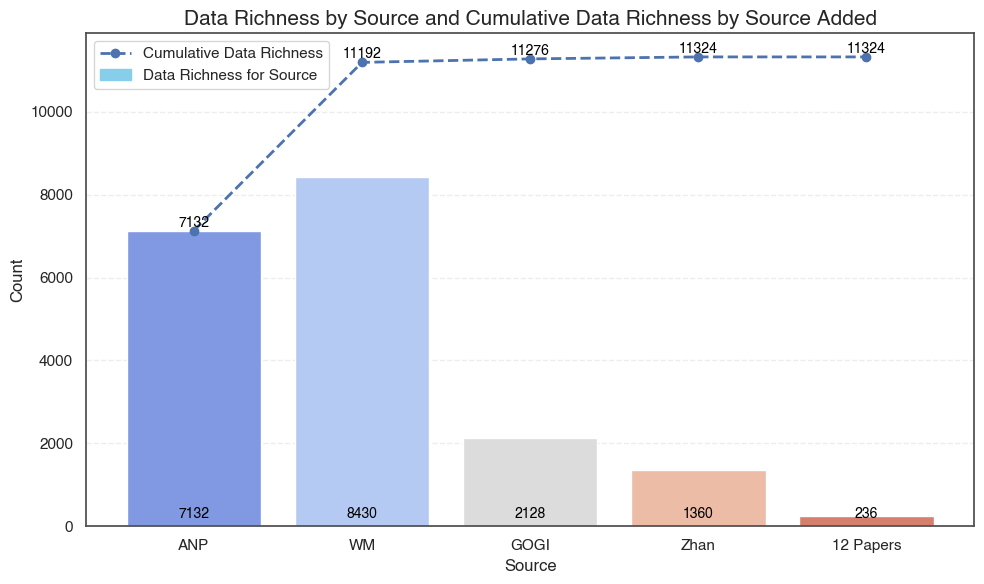

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import json
import os

# Load OPGEE columns from JSON
with open('../data/OPGEE_cols.json', 'r') as json_file:
    OPGEE_cols = json.load(json_file)
OPGEE_cols['geometry'] = 'geo'  # Add a column

def count_non_null_cells(df):
    return df.count().sum()

# File paths
base_path = '../data/br_geodata'
merged_paths = [f'{base_path}/pyxis_middle_version/merged_pyxis_field_info_table_v{i}.csv' for i in range(1, 6)]
source_info_paths = [f"{base_path}/data_standardization/{src}.csv" for src in [
    'anp', 'wm', 'gogi', 'zhan', 'arma-10-162', 'otc-8879-ms', 'otc-21934-ms',
    'otc-22612-ms', 'otc-30780-ms', 'otc-31900-ms', 'seg-2005-2645',
    'seg-2018-2990024', 'spe-94706-ms', 'spe-140145-ms', 'spe-162323-ms', 'spe-210009-ms'
]]

# Load and filter merged data
merged_data = [pd.read_csv(path).filter(items=OPGEE_cols.keys()) for path in merged_paths]
OPGEE_data_richness = {
    'ANP': count_non_null_cells(merged_data[0]),
    'WM': count_non_null_cells(merged_data[1]),
    'GOGI': count_non_null_cells(merged_data[2]),
    'Zhan': count_non_null_cells(merged_data[3]),
    '12 Papers': count_non_null_cells(merged_data[4])
}

# Load and filter source data
source_data = [pd.read_csv(path).filter(items=OPGEE_cols.keys()) for path in source_info_paths]
cnt = sum(count_non_null_cells(source_data[i]) for i in range(4, len(source_data)))
data_richness = {
    'ANP': count_non_null_cells(source_data[0]),
    'WM': count_non_null_cells(source_data[1]),
    'GOGI': count_non_null_cells(source_data[2]),
    'Zhan': count_non_null_cells(source_data[3]),
    '12 Papers': cnt
}

# Create DataFrame for plotting
df = pd.DataFrame({
    'Source': list(data_richness.keys()),
    'Data Richness': list(data_richness.values()),
    'OPGEE Data Richness': list(OPGEE_data_richness.values())
})

# Plotting with Seaborn and Matplotlib
sns.set(style="whitegrid", rc={"grid.color": ".9", "axes.edgecolor": ".3"})
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Source', y='Data Richness', data=df, palette='coolwarm', label='Data Richness for Source')

# Add data labels for the bar plot
for index, row in df.iterrows():
    plt.text(index, 200, str(row['Data Richness']), color='black', ha="center", fontsize=10)

# Add line plot for cumulative OPGEE data richness
plt.plot(df['Source'], df['OPGEE Data Richness'], marker='o', linewidth=2, linestyle='--', label='Cumulative Data Richness')

# Add data labels for the line plot
for index, row in df.iterrows():
    plt.text(index, row['OPGEE Data Richness'] + 100, str(row['OPGEE Data Richness']), color='black', ha="center", fontsize=10)

# Customize plot
plt.title('Data Richness by Source and Cumulative Data Richness by Source Added', weight='bold', fontsize=15)
plt.xlabel('Source')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add custom legend
custom_legend = [plt.Line2D([0], [0], lw=2, linestyle='--', marker='o', label='Cumulative Data Richness'),
                 mpatches.Patch(label='Data Richness for Source', color='skyblue')]
plt.legend(handles=custom_legend, loc='best')

plt.tight_layout()
plt.savefig(f'{base_path}/plots/Data_richness_plot.svg', format='svg', dpi=300)
plt.show()